# SVM——Rental Listing Inquiries 数据集

Kaggle 平台上的一个分类竞赛任务，需要根据公寓的特征来预测其受欢迎程度（用户感兴趣程度分为高、中、低三类）。

LinearSVC 进行参数调优。评价标准为 logloss

## 作业要求的 RBF 的 SVM 参见 SVM2_RentListingInqueries
 RBF 的 SVM 训练时间太长，所以先提交了这个。
 延长作业时间后，又做了  RBF 的 SVM 

In [1]:
# 首先 import 必要的包包
import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import log_loss  
# SVM 并不能直接输出各类的概率，所以在这个例子中我们用正确率作为模型预测性能的度量
from sklearn.metrics import accuracy_score

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据 & 数据探索
数据用特征工程之后的。已经进行了标准化。

In [2]:
dpath = './data/'
# 训练数据
train = pd.read_csv(dpath +"RentListingInquries_FE_train.csv")
train.head()

,bathrooms,bedrooms,latitude,longitude,price,price_bathrooms,price_bedrooms,room_diff,room_num,top_10_manager,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,0.574016,1.307938,-0.042355,0.011220,-0.037621,-0.045241,-0.116088,-1.235108,1.207530,1,...,0,0,0,0,0,0,0,0,0,1
1,-0.423163,0.411083,0.083246,-0.009325,0.074086,0.094018,0.020990,-0.707528,0.170240,1,...,0,0,0,0,0,0,0,0,0,2
2,-0.423163,-0.485772,-0.004299,-0.039124,-0.044419,-0.024795,-0.029748,0.347633,-0.521286,1,...,0,0,0,0,0,0,0,0,0,0
3,-0.423163,-0.485772,0.019349,-0.010174,-0.025159,-0.005485,-0.002567,0.347633,-0.521286,1,...,0,0,0,0,0,0,0,0,0,2
4,-0.423163,2.204793,0.129290,0.005447,-0.021760,-0.002078,-0.126321,-2.817850,1.553293,0,...,0,0,1,0,0,0,0,0,0,2


In [3]:
# 测试数据
test = pd.read_csv(dpath +"RentListingInquries_FE_test.csv")
test.head()

,listing_id,bathrooms,bedrooms,latitude,longitude,price,price_bathrooms,price_bedrooms,room_diff,room_num,...,virtual,walk,walls,war,washer,water,wheelchair,wifi,windows,work
0,7142618,-0.423163,-0.485772,-0.036090,-0.026135,-0.039887,-0.020252,-0.023352,0.347633,-0.521286,...,0,0,0,0,0,0,0,0,0,0
1,7210040,-0.423163,0.411083,-0.021526,-0.037596,-0.044419,-0.024795,-0.090506,-0.707528,0.170240,...,0,0,0,1,0,0,0,0,0,0
2,7103890,-0.423163,-0.485772,-0.017141,-0.028257,-0.003271,0.016460,0.028324,0.347633,-0.521286,...,0,0,0,0,0,0,0,0,0,0
3,7143442,-0.423163,0.411083,-0.047993,-0.001175,-0.024026,-0.004349,-0.071319,-0.707528,0.170240,...,0,0,0,0,0,0,1,0,0,0
4,6860601,1.571195,0.411083,0.036733,-0.024437,0.048482,-0.005864,-0.003100,0.347633,0.861767,...,0,0,0,1,0,0,0,0,0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Columns: 219 entries, bathrooms to interest_level
dtypes: float64(9), int64(210)
memory usage: 82.5 MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74659 entries, 0 to 74658
Columns: 219 entries, listing_id to work
dtypes: float64(9), int64(210)
memory usage: 124.7 MB


In [6]:
# 各属性的统计特性
train.describe()

,bathrooms,bedrooms,latitude,longitude,price,price_bathrooms,price_bedrooms,room_diff,room_num,top_10_manager,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
count,4.935200e+04,4.935200e+04,4.935200e+04,4.935200e+04,4.935200e+04,4.935200e+04,4.935200e+04,4.935200e+04,4.935200e+04,49352.000000,...,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000
mean,2.964299e-17,2.648709e-15,-3.630831e-15,2.854481e-15,5.933519e-17,-1.307700e-16,-3.395913e-17,4.457247e-16,-1.357776e-15,0.605751,...,0.003080,0.000385,0.186477,0.009361,0.000446,0.028165,0.002026,0.001013,0.000952,1.616895
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,0.488694,...,0.055412,0.019618,0.389495,0.101625,0.021109,0.165446,0.044969,0.031814,0.030846,0.626035
min,-2.417520e+00,-1.382628e+00,-6.380533e+01,-3.762228e+01,-1.716244e-01,-1.523321e-01,-2.065213e-01,-4.928172e+00,-1.904339e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.231625e-01,-4.857723e-01,-2.074272e-02,-3.054969e-02,-6.027986e-02,-4.296934e-02,-7.558277e-02,-7.075278e-01,-5.212861e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,-4.231625e-01,-4.857723e-01,1.606063e-02,-1.883392e-02,-3.082363e-02,-1.797992e-02,-3.506687e-02,3.476331e-01,-5.212861e-01,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,-4.231625e-01,4.110829e-01,5.129788e-02,7.772486e-04,1.222778e-02,1.382480e-02,3.900444e-02,3.476331e-01,8.617668e-01,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,1.752606e+01,5.792214e+00,6.486716e+00,6.278607e+01,2.033010e+02,2.038502e+02,1.912286e+02,8.788921e+00,7.431268e+00,1.000000,...,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [7]:
# 各属性的统计特性
test.describe()

,listing_id,bathrooms,bedrooms,latitude,longitude,price,price_bathrooms,price_bedrooms,room_diff,room_num,...,virtual,walk,walls,war,washer,water,wheelchair,wifi,windows,work
count,7.465900e+04,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,...,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000
mean,7.024001e+06,0.001466,0.002712,-0.010156,0.008858,-0.003677,-0.003571,-0.003356,-0.002415,0.002599,...,0.001058,0.003094,0.000442,0.188243,0.008653,0.000388,0.027994,0.002156,0.001085,0.000884
std,1.264496e+05,1.295973,0.992831,1.263352,1.263091,0.440171,0.433629,0.573325,1.082757,1.035559,...,0.032922,0.055539,0.021020,0.390908,0.097548,0.019705,0.164957,0.046388,0.032921,0.029720
min,6.811958e+06,-2.417520,-1.382628,-63.805329,-40.353413,-0.173528,-0.154240,-0.211979,-5.983333,-1.904339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.915516e+06,-0.423163,-0.485772,-0.021526,-0.030635,-0.060506,-0.043424,-0.075796,-0.707528,-0.521286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.021738e+06,-0.423163,-0.485772,0.015747,-0.018664,-0.030824,-0.017980,-0.035824,0.347633,-0.521286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.129166e+06,-0.423163,0.411083,0.051298,0.000862,0.012228,0.013825,0.037406,0.347633,0.861767,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.761779e+06,220.950557,4.895359,3.337602,62.786074,75.732855,75.949852,71.205126,115.360176,77.621201,...,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


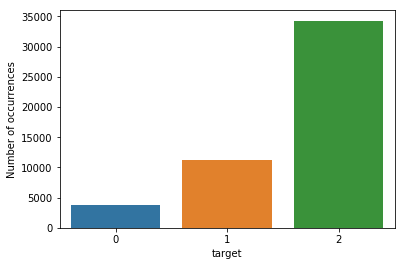

In [8]:
# Target 分布，看看各类样本分布是否均衡
sns.countplot(train.interest_level);
pyplot.xlabel('target');
pyplot.ylabel('Number of occurrences');

各类样本不均衡。交叉验证对分类任务缺省的是采用StratifiedKFold，在每折采样时根据各类样本按比例采样
## 分离目标值和输入特征

In [9]:
y_train = train['interest_level']
X_train = train.drop(["interest_level"], axis=1)

# listing_id 用于输出预测结果
listing_id_test = test['listing_id']
X_test = test.drop(["listing_id"], axis=1)

# 如果计算资源有限，也可只取少量样本，如取前1000个样本
## 训练样本有 49352 个，我电脑最多能取 50%
## 老师批改作业时，如果计算资源充足，可以试一下全体样本，谢谢！

In [10]:
#将数据分割
from sklearn.model_selection import train_test_split

# 随机采样数据构建测试样本 test_size 是测试样本比例，其余作为训练样本
# 注意，这里的 test 其实是校验集，不是测试数据，
# 下面只用到了部分训练集，所以用后缀 _part
X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X_train, y_train, random_state=33, test_size=0.5)

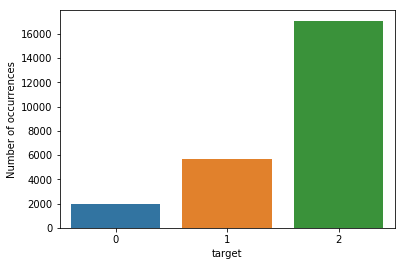

In [11]:
# Target 分布，看看各类样本分布是否均衡
sns.countplot(y_train_part);
pyplot.xlabel('target');
pyplot.ylabel('Number of occurrences');

In [12]:
# 把 DataFrame 转换为 二维数组，用于模型训练
X_train_part = np.array(X_train_part)

## 模型训练
### 默认的 SVC

In [13]:
from sklearn.svm import LinearSVC

SVC1 = LinearSVC().fit(X_train_part, y_train_part)

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#在校验集上测试，估计模型性能
y_predict = SVC1.predict(X_test_part)

print("Classification report for classifier %s:\n%s\n"
      % (SVC1, classification_report(y_test_part, y_predict)))
print("Confusion matrix:\n%s" % confusion_matrix(y_test_part, y_predict))

Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0):
             precision    recall  f1-score   support

          0       0.29      0.01      0.02      1905
          1       0.40      0.10      0.16      5568
          2       0.72      0.97      0.83     17203

avg / total       0.61      0.70      0.61     24676


Confusion matrix:
[[   20   335  1550]
 [   27   545  4996]
 [   23   467 16713]]


默认的这个模型性能不高，下面继续尝试添加正则项的模型

### 线性SVM正则参数调优

用校验集（X_test_part、y_test_part）来估计模型性能

In [15]:
def fit_grid_point_Linear(C, X_train, y_train, X_val, y_val):
    
    # 在训练集是那个利用SVC训练
    SVC2 =  LinearSVC( C = C)
    SVC2 = SVC2.fit(X_train, y_train)
    
    # 在校验集上返回accuracy
    accuracy = SVC2.score(X_val, y_val)
    
    print("accuracy: {}".format(accuracy))
    return accuracy

accuracy: 0.6968309288377371
accuracy: 0.6965877775976658
accuracy: 0.6984114118982007
accuracy: 0.7010455503323066
accuracy: 0.7007213486788783
accuracy: 0.700194520992057
accuracy: 0.6993434916518074


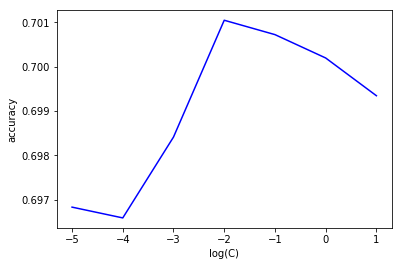

In [17]:
#需要调优的参数
C_s = np.logspace(-5, 1, 7)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份  

accuracy_s = []
for i, oneC in enumerate(C_s):
    tmp = fit_grid_point_Linear(oneC, X_train_part, y_train_part, X_test_part, y_test_part)
    accuracy_s.append(tmp)

x_axis = np.log10(C_s)
pyplot.plot(x_axis, np.array(accuracy_s), 'b-')
    
pyplot.legend()
pyplot.xlabel( 'log(C)' )                                                                                                      
pyplot.ylabel( 'accuracy' )
pyplot.savefig('SVM_RentListingInqueries.png' )

pyplot.show()

#### log(C) = -2 的位置是最佳，准确率最高。
#### 最好在 -2 附近继续搜索，时间太紧张，先交作业。

### 用最佳的 C 训练模型 SVC2

In [19]:
SVC2 =  LinearSVC( C = C_s[3])
SVC2 = SVC2.fit(X_train_part, y_train_part)

## 使用最佳的 SVC2 预测，输出结果

In [20]:
y_predict = SVC2.predict(X_test)
result = pd.DataFrame(y_predict, columns=['interest_level'])
result = pd.concat([listing_id_test, result], axis = 1)
result.to_csv(dpath+'RentListingInquries_LinearSVC2.csv', index=False)

In [21]:
y_predict.shape

(74659,)